<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [107]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0-rc1

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

# Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

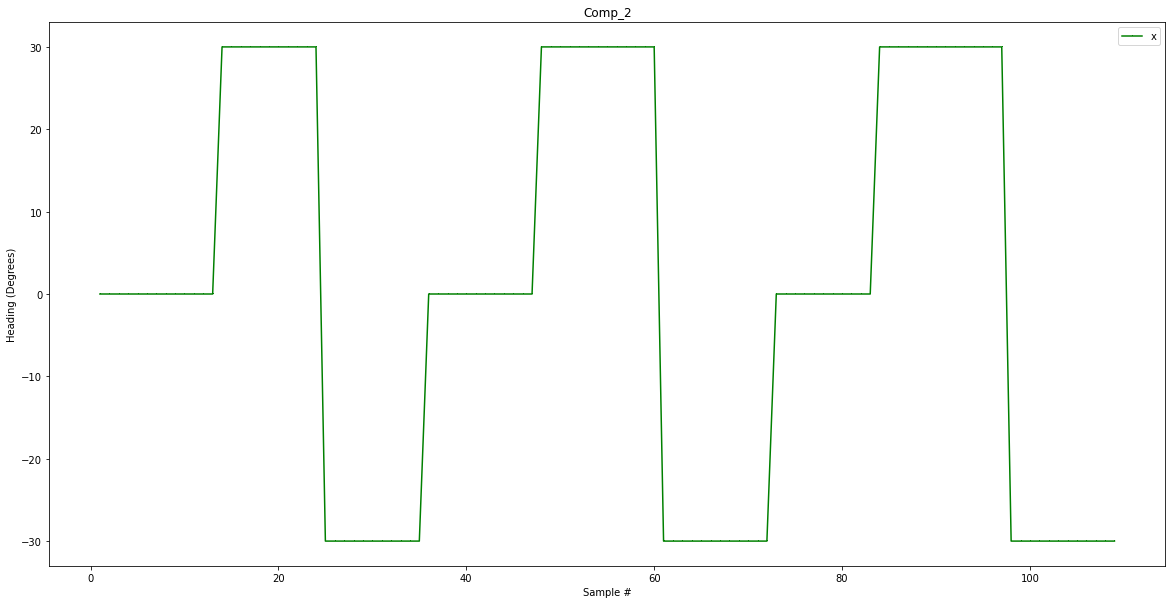

(109, 11)


In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "data.csv"

df = pd.read_csv("/content/" + filename)

np_df = np.genfromtxt(filename, delimiter=",", skip_header=1)

index = range(1, len(df['Comp_1']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['Degrees'], 'g.', label='x', linestyle='solid', marker=',')
# plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
# plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Comp_2")
plt.xlabel("Sample #")
plt.ylabel("Heading (Degrees)")
plt.legend()
plt.show()

print(np_df.shape)



# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

filename = "data.csv"

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1367
np.random.seed(SEED)
tf.random.set_seed(SEED)

np_df = np.genfromtxt(filename, delimiter=",", skip_header=1)

inputs = np_df[:,0:9]
inputs[:,0] = 0 # inputs[:,0]/360
inputs[:,4] = 0 # inputs[:,4]/360
inputs[:,8] = inputs[:,8]/360
# outputs = np_df[:,9:10]
outputs = np_df[:,10:11]
# outputs[:,0] = outputs[:,0]/10
outputs[:,0] = (outputs[:,0]+30)/60

# calculate the number of gesture recordings in the file
num_recordings = np_df.shape[0]
print(num_recordings)
print(inputs.shape)
print(outputs.shape)
print(inputs)
print(outputs)

TensorFlow version = 2.0.0-rc1

109
(109, 9)
(109, 1)
[[0.00000000e+00 2.00000000e+02 8.00000000e+00 2.90000000e+01
  0.00000000e+00 2.80000000e+01 3.00000000e+01 7.10000000e+01
  4.80555556e-01]
 [0.00000000e+00 4.40000000e+01 8.00000000e+00 2.80000000e+01
  0.00000000e+00 3.00000000e+01 1.70000000e+02 2.40000000e+01
  5.77777778e-01]
 [0.00000000e+00 1.73000000e+02 8.00000000e+00 3.30000000e+01
  0.00000000e+00 1.90000000e+01 2.07000000e+02 9.00000000e+00
  6.63888889e-01]
 [0.00000000e+00 1.40000000e+02 8.00000000e+00 1.90000000e+01
  0.00000000e+00 4.00000000e+00 1.62000000e+02 3.70000000e+01
  7.41666667e-01]
 [0.00000000e+00 1.98000000e+02 6.00000000e+00 2.10000000e+01
  0.00000000e+00 3.40000000e+01 7.90000000e+01 3.40000000e+01
  8.41666667e-01]
 [0.00000000e+00 3.30000000e+01 7.00000000e+00 1.70000000e+01
  0.00000000e+00 1.69000000e+02 2.20000000e+01 3.10000000e+01
  9.36111111e-01]
 [0.00000000e+00 1.53000000e+02 8.00000000e+00 2.00000000e+01
  0.00000000e+00 1.99000000e+02 

## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [117]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.9 * num_inputs+1)
TEST_SPLIT = int(0.1 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_validate, inputs_test = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_validate, outputs_test = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")
print(inputs_train.shape)
print(inputs_validate.shape)
print(inputs_test.shape)

Data set randomization and splitting complete.
(99, 9)
(10, 9)
(0, 9)


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [118]:
# # build the model and train it
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
# model.add(tf.keras.layers.Dense(15, activation='relu'))
# model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# history = model.fit(inputs_train, outputs_train, epochs=1800, batch_size=1, validation_data=(inputs_validate, outputs_validate))

# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(18, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='relu'))
model.add(tf.keras.layers.Dense(1)) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
#Need to change this, right now this trains on all data including validation data for deployment on Arduino. This is not good practice for general ML benchmarks.
history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Train on 99 samples, validate on 10 samples
Epoch 1/200
99/99 [==============================] - 1s 14ms/sample - loss: 27.0617 - mae: 2.6481 - val_loss: 3.5655 - val_mae: 1.4386
Epoch 2/200
99/99 [==============================] - 0s 3ms/sample - loss: 1.7425 - mae: 0.9412 - val_loss: 0.8618 - val_mae: 0.8019
Epoch 3/200
99/99 [==============================] - 0s 2ms/sample - loss: 1.3840 - mae: 0.8045 - val_loss: 0.4640 - val_mae: 0.5066
Epoch 4/200
99/99 [==============================] - 0s 3ms/sample - loss: 0.7123 - mae: 0.6198 - val_loss: 0.9769 - val_mae: 0.8013
Epoch 5/200
99/99 [==============================] - 0s 2ms/sample - loss: 0.6947 - mae: 0.5884 - val_loss: 0.5914 - val_mae: 0.6572
Epoch 6/200
99/99 [==============================] - 0s 2ms/sample - loss: 0.6462 - mae: 0.6084 - val_loss: 0.5703 - val_mae: 0.6812
Epoch 7/200
99/99 [==============================] - 0s 2ms/sample - loss: 0.4652 - mae: 0.5045 - val_loss: 1.2060 - val_mae: 0.8572
Epoch 8/200
99/99 [====

In [89]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            multiple                  300       
_________________________________________________________________
dense_110 (Dense)            multiple                  558       
_________________________________________________________________
dense_111 (Dense)            multiple                  228       
_________________________________________________________________
dense_112 (Dense)            multiple                  13        
Total params: 1,099
Trainable params: 1,099
Non-trainable params: 0
_________________________________________________________________


## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

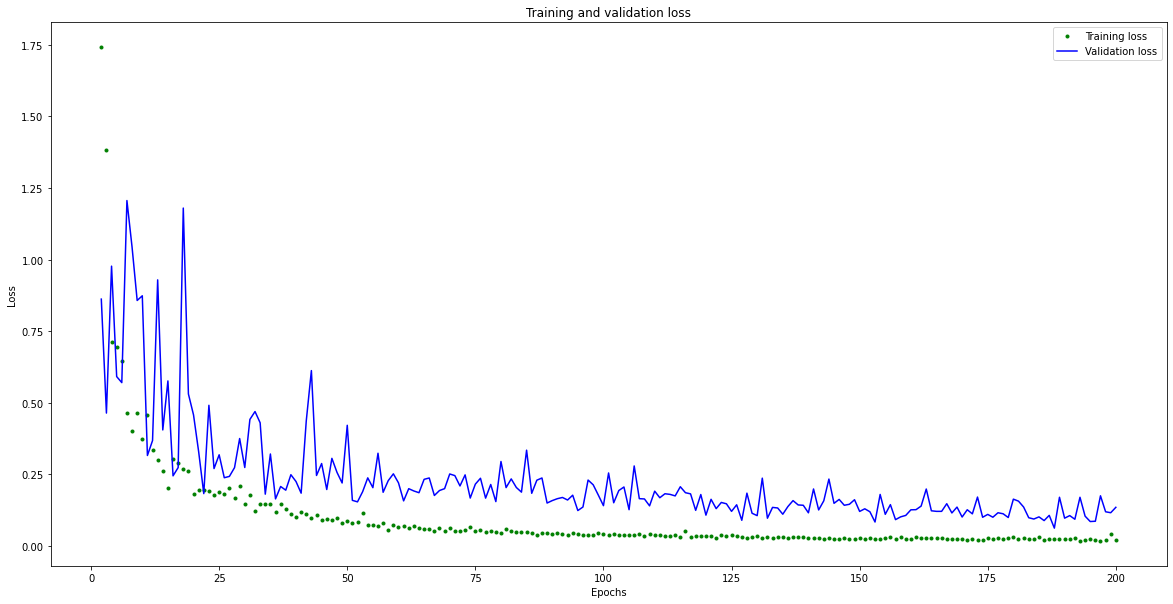

[20.0, 10.0]


In [119]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs[1:], loss[1:], 'g.', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

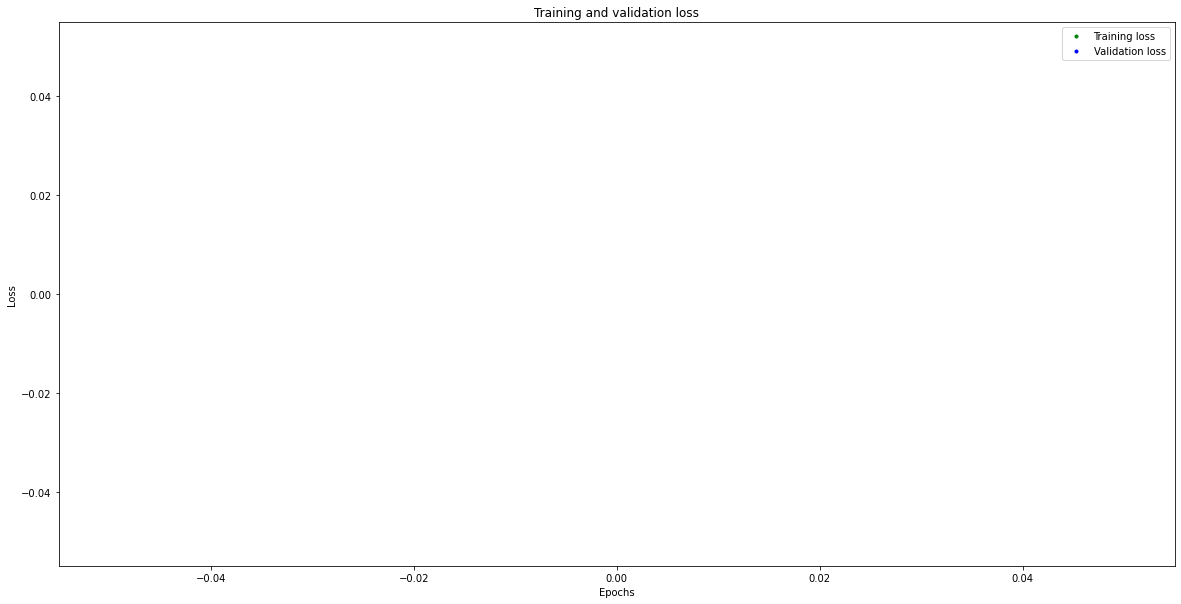

In [47]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



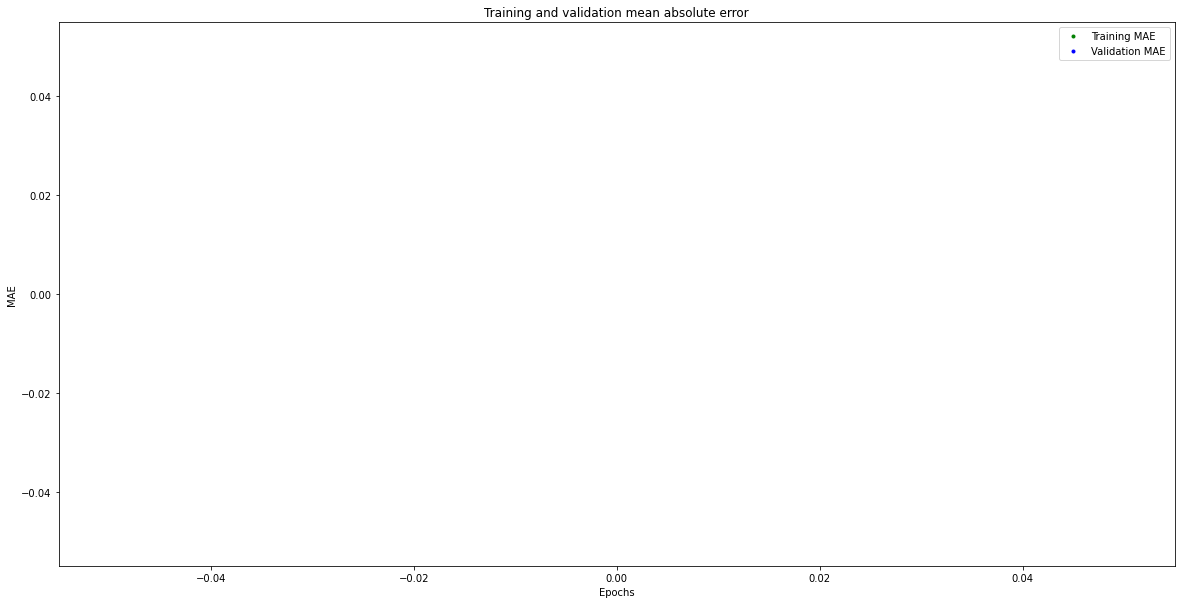

In [48]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and plot the predictions


predictions =
 [[0.678]
 [0.559]
 [0.597]
 [0.666]
 [0.519]
 [0.613]
 [0.711]
 [0.568]
 [0.519]
 [0.548]]
actual =
 [[0.7]
 [0.6]
 [0.6]
 [0.5]
 [0.5]
 [0.6]
 [0.7]
 [0.6]
 [0.6]
 [0.5]]


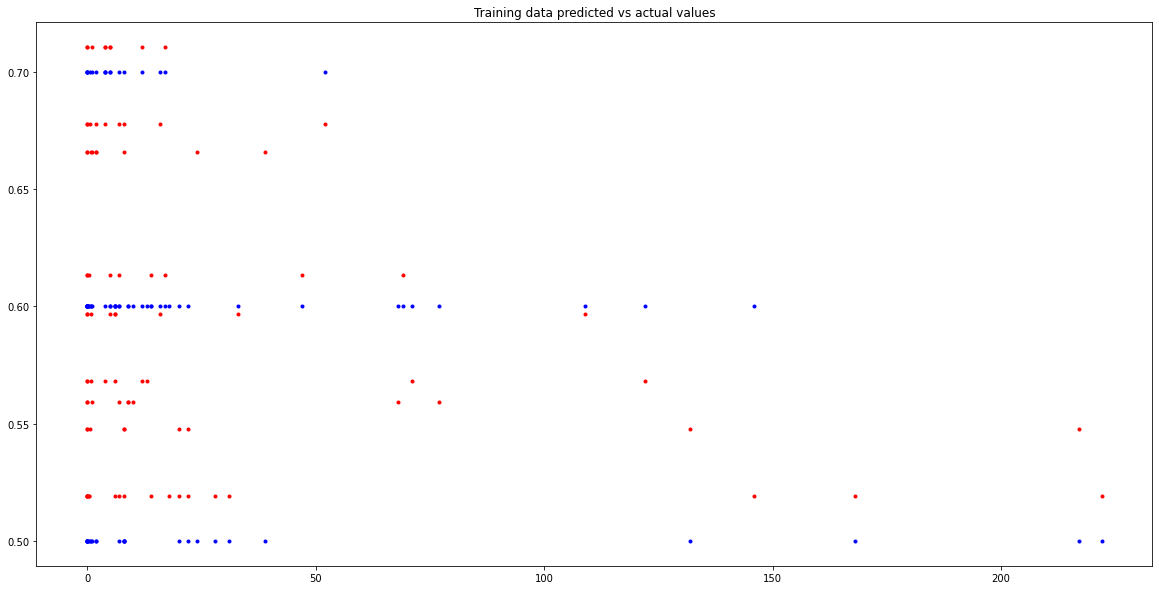

In [115]:
# use the model to predict the test inputs
predictions = model.predict(inputs_validate)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_validate)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_validate, outputs_validate, 'b.', label='Actual')
plt.plot(inputs_validate, predictions, 'r.', label='Predicted')
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [105]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("angle_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("angle_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Model is 6212 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [106]:
!echo "const unsigned char model[] = {" > /content/angle_model.h
!cat angle_model.tflite | xxd -i      >> /content/angle_model.h
!echo "};"                              >> /content/angle_model.h

import os
model_h_size = os.path.getsize("dist_model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click angle_model.h to download the file.")

Header file, model.h, is 38,342 bytes.

Open the side panel (refresh if needed). Double click angle_model.h to download the file.


# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
